<a href="https://colab.research.google.com/github/David-Carballo/2023w-project-pose/blob/main/Mobilenet_image_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.utils import list_files
from torchvision.datasets.folder import pil_loader
from torchvision.utils import make_grid
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from PIL import Image
import os

device = 'cuda'

In [ ]:
class YogaPoses(Dataset):
    def __init__(self, root = 'Yoga', transform = None, loader = pil_loader):
      self.root = Path(root)
      self.filenames = list_files(self.root, suffix = ('.jpeg', '.png', '.jpg'), prefix = False)
      self.loader = loader
      self.transform = transform
      self.resize = transforms.Resize(224)
      self.labels = self.get_labels(self.filenames)

    def __getitem__(self, index):
      filename = self.root / self.filenames[index]
      image = self.loader(filename)
      to_tensor = transforms.ToTensor()
      tensor = to_tensor(image)
      tensor = self.image_transforms(tensor)
      label = self.labels[index]
      return tensor, label

    def image_transforms(self, tensor):
      #Check if image size ratio is 1:1
      if tensor.shape[1] != tensor.shape[2]:
        #Calculate difference between X and Y axis
        diff = tensor.shape[1] - tensor.shape[2]
        if diff > 0: #We check what dimension needs to be padded either the X (dimension 1 of the tensor, right), or the Y (dimension 3, bottom)
          tensor = F.pad(input=tensor, pad=(0, abs(diff), 0, 0), mode='constant', value=0) #pad(left, right, top, bottom)
        else:
          tensor = F.pad(input=tensor, pad=(0, 0, 0, abs(diff)), mode='constant', value=0)
      tensor = self.resize(tensor)
      tensor = tensor.reshape(3, 224, 224)
      return tensor

    def get_labels(self, filenames):
      labels = []
      for filename in filenames:
        label = filename.split('_')[0]
        if label == 'Italian greyhound':
            labels.append(171)
        elif label == 'Bison':
            labels.append(347)
      return labels

    def __len__(self):
      return len(self.filenames)

In [ ]:
dataset = YogaPoses()
print('Number of images', len(dataset))
print(dataset[2])

Number of images 5
(tensor([[[0.8549, 0.8863, 0.9059,  ..., 0.8745, 0.8431, 0.8118],
         [0.8588, 0.8902, 0.9176,  ..., 0.8980, 0.8588, 0.8353],
         [0.8941, 0.9176, 0.9373,  ..., 0.8824, 0.8431, 0.8078],
         ...,
         [0.7294, 0.7608, 0.7412,  ..., 0.0588, 0.0627, 0.0627],
         [0.7333, 0.7216, 0.7294,  ..., 0.0667, 0.0667, 0.0706],
         [0.7255, 0.7451, 0.7137,  ..., 0.0627, 0.0745, 0.0784]],

        [[0.9098, 0.9412, 0.9608,  ..., 0.9412, 0.9137, 0.8863],
         [0.9137, 0.9451, 0.9765,  ..., 0.9765, 0.9451, 0.9176],
         [0.9529, 0.9765, 0.9961,  ..., 0.9686, 0.9333, 0.9098],
         ...,
         [0.7529, 0.7843, 0.7647,  ..., 0.1176, 0.1098, 0.1098],
         [0.7569, 0.7451, 0.7529,  ..., 0.1255, 0.1255, 0.1294],
         [0.7490, 0.7686, 0.7373,  ..., 0.1216, 0.1255, 0.1294]],

        [[0.9608, 0.9843, 0.9961,  ..., 0.9725, 0.9686, 0.9451],
         [0.9569, 0.9804, 1.0000,  ..., 1.0000, 0.9961, 0.9843],
         [0.9804, 1.0000, 1.0000,  ...

TypeError: ignored

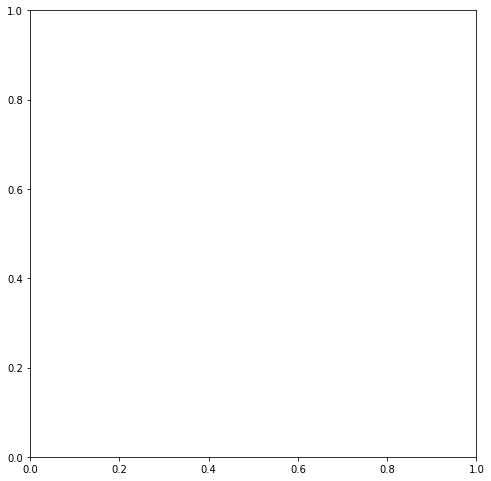

In [ ]:
plt.figure(figsize=(8, 10))
plt.imshow(dataset[4])
plt.xticks([]); plt.yticks([]); plt.grid(False)

In [ ]:
for image, label in dataset:
  shape = torchvision.transforms.functional.get_image_size(image)
  print (shape)

[224, 224]
[224, 224]
[224, 224]
[224, 224]
[224, 224]


In [ ]:
loader = DataLoader(dataset, batch_size=4, num_workers=4, shuffle=False)

print(len(loader))

2


In [ ]:
model = torchvision.models.mobilenet_v3_small(weights = 'DEFAULT')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for i, data in enumerate(loader, 0):
  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)

In [ ]:
image = dataset[0]
image = image.to(device)

with torch.no_grad():
    image_features = model(image.unsqueeze(0))
    image_features = torch.squeeze(image_features).cpu().numpy()

new_shape = (112, 112)  # Change to your desired shape
#image_features_resized = F.interpolate(torch.from_numpy(image_features).unsqueeze(0), size=new_shape).squeeze().numpy()


print(image_features)

[4.0404773  4.412816   4.493373   3.850099   3.9267192  2.533846
 3.281327   3.563717   3.3210974  2.5425596  2.6575904  3.1062546
 3.373972   3.965509   2.7048826  3.181779   4.3900256  3.4514725
 3.550149   4.1515784  2.4959922  3.6862714  4.130313   3.2710538
 2.898094   2.4761376  1.7960247  2.0409586  2.5529213  4.4148703
 2.6781871  2.245975   2.0994804  3.5129356  2.6119003  2.1086454
 2.9840055  2.9268646  3.244699   3.006138   2.05739    2.417854
 1.8236097  2.6751678  2.7346373  3.6158655  2.8432262  2.5339649
 2.1800306  1.7803351  1.7253014  4.5772896  2.582023   3.201216
 2.1400964  2.8541257  2.4985979  2.8836727  2.486033   3.3264282
 2.129922   3.1021326  2.217208   4.002067   3.314918   2.808739
 2.5726802  2.102783   2.231672   1.7704246  1.3435647  3.6618595
 3.4566371  1.7464504  1.9311118  2.6633146  3.890945   2.0752127
 2.721805   2.2143276  2.1124506  2.2522995  1.6224269  2.5961053
 3.647903   3.296995   2.005514   5.710087   3.1628375  4.9296937
 3.3312244  2.

In [ ]:
features = []
n_batches = len(loader)

with torch.no_grad():
    for i, batch in enumerate(loader):
      batch = batch.to(device)

      batch_features = model(batch)
      batch_features = torch.squeeze(batch_features).cpu().numpy()

      features.append(batch_features)


print(features[0])


#plt.imshow(features[0])
#plt.show()



[[-0.22655696  1.1787976  -1.8354105  ... -1.3852838   1.137629
   3.1169293 ]
 [ 1.6137236   0.9632306  -1.1308563  ...  0.06139129  0.1984809
   2.8867288 ]
 [ 0.00638574 -2.2306373  -0.16500013 ... -1.5055244  -0.1290046
   3.0629592 ]
 [-1.0336748   0.5523132  -1.4829895  ... -1.2955451   3.2649722
   1.3845459 ]
 [-1.8208915  -2.2068217  -0.37908575 ... -1.7579634  -0.8773681
  -0.9803128 ]]


In [ ]:
def test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted)
            print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy on the test set: %d %%' % (accuracy))

In [ ]:
testloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
test(model, testloader, device)

tensor([171], device='cuda:0')
tensor([171], device='cuda:0')
tensor([343], device='cuda:0')
tensor([347], device='cuda:0')
tensor([347], device='cuda:0')
tensor([347], device='cuda:0')
tensor([171], device='cuda:0')
tensor([171], device='cuda:0')
tensor([347], device='cuda:0')
tensor([347], device='cuda:0')
Accuracy on the test set: 80 %
